# Global validation for all models at once 

Load the global data and get the predictions for all models. 

Visualization and statistics of all three aproaches x2 swaths

TODO:   
    - Violin plots of all distributions of errors (3 models x 2 swaths = 6)  
    - Table with rmse and bias for all 6  

In [2]:
# Imports
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

import sys
import os

from tensorflow.keras.models import load_model
import pickle

from matplotlib.colors import CenteredNorm
from sklearn.metrics import mean_squared_error
from scipy.stats import kstest

sys.path.append("../..")

from src.processing import windsat_datacube, create_landmask, model_preprocess, \
    telsem_datacube, doy2month_mapping
from src.model import create_training_df, plot_history, xy_split

# Files
ws_path = "../../data/raw/daily_windsat/"
telsem_folder = r"..\..\data\processed\WindsatEmiss"

# For visualization
from matplotlib.colors import LinearSegmentedColormap



In [3]:
# Define / load the models

regressions = { # Swath : (a,b)
    0 : (0.56, 138.29),
    1 : (0.54 , 142.98)
}

model_folder = "..\..\models"
# model_strings ={ # Name : stringID
#     "Modelv1_Asc": "WSMv1_A_2024_07_23T135732",
#     "Modelv1_Des": "WSMv1_D_2024_07_23T120006",
#     "Modelv2_Asc": "WSMv2_A_2024_07_23T202640",
#     "Modelv2_Des": "WSMv2_D_2024_07_23T180208"
# }

modelsv1 = {
    0 : load_model(os.path.join(model_folder, "WSMv1_A_2024_07_23T135732" + ".keras")),
    1 : load_model(os.path.join(model_folder, "WSMv1_D_2024_07_23T120006" + ".keras")),
}

modelsv2 = {
    0 : load_model(os.path.join(model_folder, "WSMv2_A_2024_07_23T202640" + ".keras")),
    1 : load_model(os.path.join(model_folder, "WSMv2_D_2024_07_23T180208" + ".keras")),
}

# Testing it works
modelsv1[0].summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 6)              │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 60)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,243 (32.20 KB)

 Trainable params: 2,743 (10.71 KB)

 Non-trainable params: 12 (48.00 B)

 Optimizer params: 5,488 (21.44 KB)

In [4]:
# Preprocessing of TELSEM atlas:
telsem_ds = telsem_datacube(telsem_folder)
telsem_df = telsem_ds.to_dataframe().dropna().reset_index("month")

In [5]:
# Preprocessing of windsat datacube
ws_ds = windsat_datacube(ws_path)

In [8]:
def get_swath_stats(ws_ds: xr.Dataset, telsem_df: pd.DataFrame, swath: int, plot_maps: bool = False):
    """ 
    THIS IS A CONVENIENCE FUNCTION THAT RELIES ON DATASETS (and aux data) BEEING LOADED "IN SCOPE" TU RUN. 

    Compute the model predictions for the same swath, get the error distribution and save it for the violin plot later
    if plot map is active, plot the average error per pixel map, all models in the same colormap

    """

    swath2name = {
        0 : "Asc",
        1 : "Des"
    }

    # Commun preprocessing
    swath_ds= model_preprocess(ws_ds, swath_sector=swath, look="impute",add_look_flag=False)
    swath_ds = swath_ds.roll({
    "longitude_grid" : 180 * 4
    })

    # Save all errors for violin plot later
    all_errors = {}

    ## LINEAR MODEL
    print("Linear Model")
    a, b = regressions[swath]

    linear_ds = swath_ds[["tbtoa_37Ghz_V","surtep_ERA5","lat","lon"]]

    if plot_maps:
        linear_ds = linear_ds.swap_dims({
            "latitude_grid": "lat",
            "longitude_grid": "lon"
        })

        linear_ds["lat"] = linear_ds.lat.sortby("lat")
        linear_ds["lon"] = linear_ds.lon.sortby("lon")

    # Compute error
    linear_ds["surtep_MODEL"] = linear_ds.tbtoa_37Ghz_V * a + b
    linear_ds["error"] = linear_ds.surtep_ERA5 - linear_ds.surtep_MODEL

    # Stats
    error_data = linear_ds["error"].values.flatten()
    error_data = error_data[~np.isnan(error_data)]

    # Save error distribution
    all_errors["Linear-Swath"] = error_data # TODO: swath2name dict for this 


    n_obs = len(error_data)

    linear_rmse = np.sqrt(((linear_ds.surtep_ERA5 - linear_ds.surtep_MODEL) ** 2).mean(skipna=True).compute())
    linear_rmse = float(linear_rmse.values)

    # Kolmogorov-Smirnov (for a normal distribution)
    mean_error = float(np.mean(error_data))
    std_error = float(np.std(error_data))

    ks_stat, ks_p = kstest(error_data, 'norm', args=(mean_error, std_error))

    # save all statins into a dataframe row
    linear_results_df = pd.DataFrame({
        "Model": "Lninear Ka V-pol",
        'Bias [K]': [mean_error],
        'std [K]': [std_error],
        'rmse [K]': [linear_rmse],
        'ks_stat': [ks_stat],
        'p-value': [ks_p],
        'n_obs' : [n_obs]
    })

    # Further processing for both NN models
    # Load Windsat data 
    d_vars = [
        "surtep_ERA5",
        "lat",
        "lon",
        "tbtoa_18Ghz_V",
        "tbtoa_18Ghz_H",
        "tbtoa_37Ghz_V",
        "tbtoa_37Ghz_H",
    ]

    swath_ds = swath_ds[d_vars]

    ## MODEL V1 ##########################
    print("Model v1")

    model = modelsv1[swath]

    combined_df = swath_ds.to_dataframe().dropna().reset_index(drop=True)

    if plot_maps:
        # Save the original lat lon for plotting later
        lat = combined_df["lat"].copy()
        lon = combined_df["lon"].copy()

    combined_df["lon"] = combined_df["lon"].apply(lambda x: np.sin(np.deg2rad(x)))
    combined_df["lat"] = combined_df["lat"].apply(lambda x: np.sin(np.deg2rad(x)))

    # Predict for the local sample:
    X, y = xy_split(combined_df, y_column = "surtep_ERA5")
    combined_df["surtep_MODEL"] = model.predict(X)
    combined_df["error"] = combined_df["surtep_ERA5"] - combined_df["surtep_MODEL"]

    if plot_maps:
        # Re add lon and lat as they were
        combined_df["lat"] = lat
        combined_df["lon"] = lon

        # Calculate the error per pixel, group by lat and lon
        v1error_df = combined_df[["lat","lon","error"]]
        v1error_df.set_index(keys=["lat","lon"], inplace=True)
        v1error_df = v1error_df.groupby(by=["lat","lon"]).mean()
        v1error_df.reset_index(inplace=True)

    # Stats
    n_obs = len(combined_df)
    rmse = np.sqrt(mean_squared_error(combined_df["surtep_MODEL"],y))

    # Kolmogorov-Smirnov (for a normal distribution)
    mean_error = combined_df["error"].mean()
    std_error = combined_df["error"].std()

    ks_stat, ks_p = kstest(combined_df["error"], 'norm', args=(mean_error, std_error))

    # save all statins into a dataframe row
    modelv1_results_df = pd.DataFrame({
        "Model" : "Model v1",
        'Bias [K]': [mean_error],
        'std [K]': [std_error],
        'rmse [K]': [rmse],
        'ks_stat': [ks_stat],
        'p-value': [ks_p],
        'n_obs' : [n_obs]
    })

    all_errors["Modelv1"] = combined_df["error"] # TODO: swath2name dict for this 


    ## MODEL V2 ##########################
    print("Model v2")

    model = modelsv2[swath]

    swath_df = swath_ds.to_dataframe().dropna().reset_index("day_number")
    day_mapping = doy2month_mapping()
    swath_df["month"] = swath_df["day_number"].apply(lambda x: day_mapping[x])
    # drop the day_number column
    swath_df = swath_df.drop(columns="day_number")

    # Inner join the telsem df and the ascending df
    combined_df = pd.merge(left=swath_df, right=telsem_df, how="inner")

    # Drop the month column
    combined_df = combined_df.drop(columns="month")

    if plot_maps:
        # Save the original lat lon for plotting later
        lat = combined_df["lat"].copy()
        lon = combined_df["lon"].copy()

    combined_df["lon"] = combined_df["lon"].apply(lambda x: np.sin(np.deg2rad(x)))
    combined_df["lat"] = combined_df["lat"].apply(lambda x: np.sin(np.deg2rad(x)))

    # Predict for the local sample:
    X, y = xy_split(combined_df, y_column = "surtep_ERA5")
    combined_df["surtep_MODEL"] = model.predict(X)
    combined_df["error"] = combined_df["surtep_ERA5"] - combined_df["surtep_MODEL"]

    if plot_maps:
        # Re add lon and lat as they were
        combined_df["lat"] = lat
        combined_df["lon"] = lon

        # Calculate the error per pixel, group by lat and lon
        v2error_df = combined_df[["lat","lon","error"]]
        v2error_df.set_index(keys=["lat","lon"], inplace=True)
        v2error_df = v2error_df.groupby(by=["lat","lon"]).mean()
        v2error_df.reset_index(inplace=True)

    # Stats
    n_obs = len(combined_df)
    rmse = np.sqrt(mean_squared_error(combined_df["surtep_MODEL"],y))

    # Kolmogorov-Smirnov (for a normal distribution)
    mean_error = combined_df["error"].mean()
    std_error = combined_df["error"].std()

    ks_stat, ks_p = kstest(combined_df["error"], 'norm', args=(mean_error, std_error))

    # save all statins into a dataframe row
    modelv2_results_df = pd.DataFrame({
        "Model" : "Model v2",
        'Bias [K]': [mean_error],
        'std [K]': [std_error],
        'rmse [K]': [rmse],
        'ks_stat': [ks_stat],
        'p-value': [ks_p],
        'n_obs' : [n_obs]
    })

    all_errors["Modelv2"] = combined_df["error"] # TODO: swath2name dict for this 



    # Compile all results

    all_results_df = pd.concat(
        [
            linear_results_df,
            modelv1_results_df,
            modelv2_results_df
        ],
        ignore_index= True
    )

    if plot_maps:
        # Custom error colomap
        color_min    = "#ff0000"
        color_center = "#BBBBBB" 
        color_max    = "#0000FF"

        error_cmap = LinearSegmentedColormap.from_list(
            "cmap_name",
            [color_min, color_center, color_max]
        )

        fig, axs = plt.subplots(3,1,figsize = (14,23), subplot_kw={"projection":ccrs.PlateCarree()} )
        norm = CenteredNorm(vcenter=0,halfrange=10, clip = False)

        """Plot linear map"""
        ax = axs[0]
        ax.coastlines("110m")
        linear_ds.error.mean(dim="day_number").plot(ax=ax,norm=norm, cmap = error_cmap, add_colorbar = False)

        # Axes format
        ax.set_title("Linear Model")

        """Plot Model v1 map"""
        ax = axs[1]
        ax.coastlines("110m")

        scatter_v1 = ax.scatter(
            x = v1error_df["lon"],
            y = v1error_df["lat"],
            s= 0.1,
            alpha = 1,
            c = v1error_df["error"],
            cmap = error_cmap,
            norm=norm
        )

        ax.set_title(f"Model v1")

        """Plot Model v2 map"""
        ax = axs[2]
        ax.coastlines("110m")

        scatter_v2 = ax.scatter(
            x = v2error_df["lon"],
            y = v2error_df["lat"],
            s= 0.1,
            alpha = 1,
            c = v2error_df["error"],
            cmap = error_cmap,
            norm=norm
        )

        ax.set_title(f"Model v2")

        # General figure settings
        fig.suptitle(f"Mean Error per pixel: Swath : {swath2name[swath]}")
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make space for the colorbar

        # Add a common colorbar
        cbar_ax = fig.add_axes([0.15, 0.02, 1, 0.02])  # Position: [left, bottom, width, height]
        fig.colorbar(scatter_v2, cax=cbar_ax, orientation='horizontal', label='Mean error per pixel [K]')

        plt.show()


    return all_results_df, all_errors

 -> Swath: 0
Linear Model
Model v1
52364/52364 ━━━━━━━━━━━━━━━━━━━━ 30s 562us/step
Model v2
52364/52364 ━━━━━━━━━━━━━━━━━━━━ 41s 790us/step


AttributeError: 'GeoAxes' object has no attribute 'coastline'

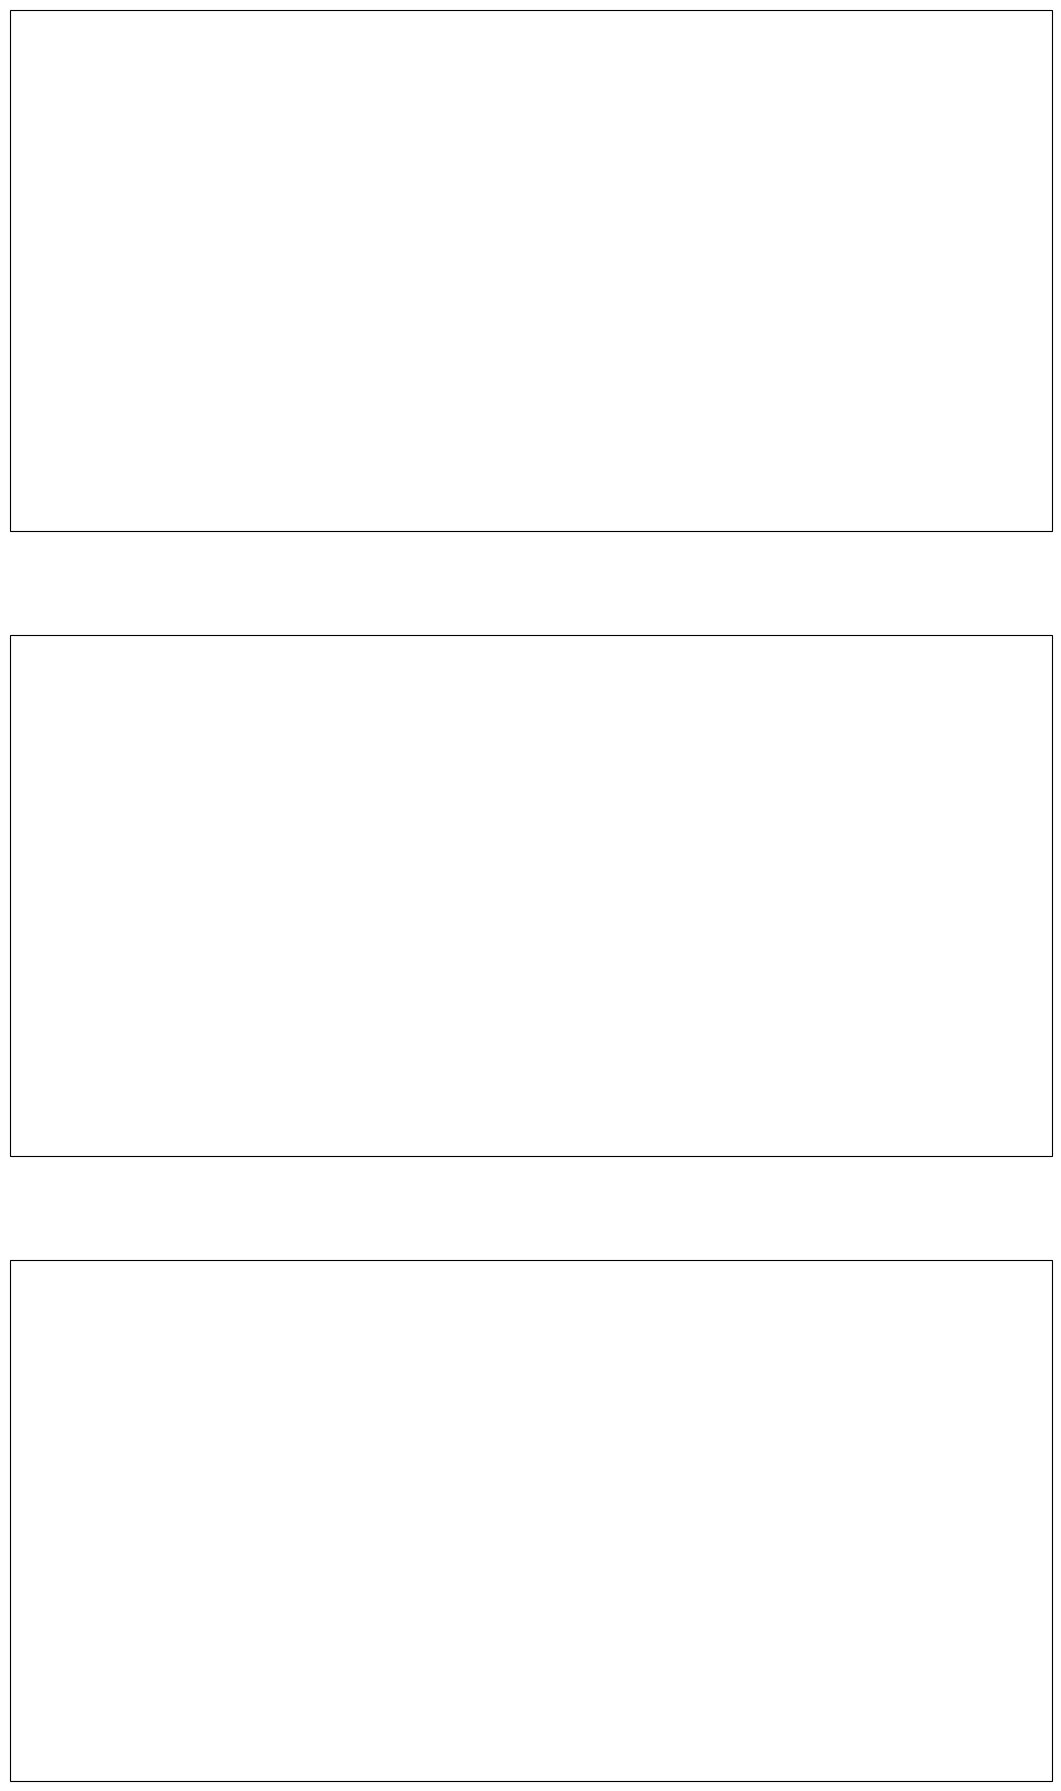

In [7]:
all_resulst_df = pd.DataFrame()
all_errors = []
for swath in (0,1):
    print(f" -> Swath: {swath}")

    swath_resutls_df, swath_errors = get_swath_stats(ws_ds, telsem_df, swath, plot_maps=True)

    all_resulst_df = pd.concat([all_resulst_df, swath_resutls_df])
    all_errors.append(pd.DataFrame(
            {
                "Swath" : swath,
                "Model": swath_errors.keys(),
                "errors" : swath_errors.values()
            }
        )
    )

all_errors_df = pd.concat(all_errors, ignore_index=True)


In [ ]:
all_resulst_df

,Model,Bias [K],std [K],rmse [K],ks_stat,p-value,n_obs
0,Lninear Ka V-pol,-0.718988,6.353931,6.394481,0.052026,0.0,1675642
1,Model v1,0.010265,2.976548,2.976566,0.053326,0.0,1675642
2,Model v2,-0.330156,2.562142,2.583326,0.046954,0.0,1675642
0,Lninear Ka V-pol,-1.716851,5.761531,6.011889,0.059528,0.0,1289282
1,Model v1,0.657143,2.781309,2.857885,0.037698,0.0,1289282
2,Model v2,-0.258346,2.303993,2.318431,0.033853,0.0,1289282


In [ ]:
columns = (3 * ["Left"])
columns.extend(["Right"]*3)
all_errors_df["Column"] = columns
all_errors_df = all_errors_df.explode("errors")


,Swath,Model,errors,Model_id,Column
0,0,Linear-Swath:Asc,"[16.836239013671843, 14.877247760913065, 13.71...",Linear-Swath:AscLinear-Swath:Asc,Left
1,0,Modelv1:Asc,0 0.056610 1 3.504517 2 ...,Modelv1:AscModelv1:Asc,Left
2,0,Modelv2:Asc,0 -7.580811 1 2.957733 2 ...,Modelv2:AscModelv2:Asc,Left
3,1,Linear-Swath:Des,"[18.662248116088904, 13.366751566452024, 4.028...",Linear-Swath:DesLinear-Swath:Des,Right
4,1,Modelv1:Des,0 -0.583649 1 -0.437469 2 ...,Modelv1:DesModelv1:Des,Right
5,1,Modelv2:Des,0 -0.581360 1 -0.501862 2 ...,Modelv2:DesModelv2:Des,Right


MemoryError: Unable to allocate 67.9 MiB for an array with shape (8894772,) and data type int64

Error in callback <function _draw_all_if_interactive at 0x000001ABDAB1D300> (for post_execute), with arguments args (),kwargs {}:


MemoryError: In RendererAgg: Out of memory

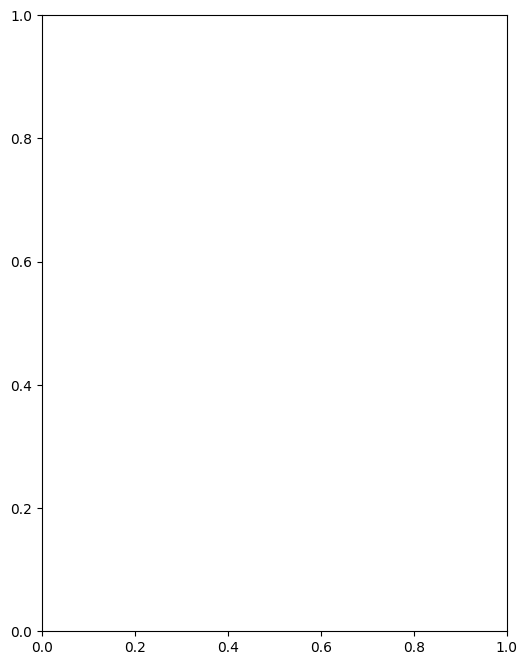

In [ ]:
# Violin plot for all swath errors:
import seaborn as sns
# Generate the violin plot

# TODO, two columns, ascending and descending

plt.figure(figsize=(6, 8))
sns.violinplot(y="Model", x='errors', data=all_errors_df, inner='box', density_norm='width', legend=False)
plt.ylabel('')
plt.xlabel('Error [K]')
plt.title('Model comparison')
plt.yticks(rotation=0)
plt.grid(axis="x")

plt.xlim([-10,10])
plt.tight_layout()
plt.show()

In [ ]:
# Violin plot for all swath errors:
import seaborn as sns
# Generate the violin plot

g = sns.FacetGrid(all_errors_df, col='Column', sharey=True, height=6, aspect=0.5)
g.map(sns.violinplot, 'errors', 'Model', inner='box', density_norm='width', orient='h')

# Set axis labels
g.set_axis_labels('Error [K]', '')

plt.show()

# plt.figure(figsize=(6, 8))
# # sns.violinplot(y="Model", x='errors', inner='box', density_norm='width', legend=False)
# plt.ylabel('')
# plt.xlabel('Error [K]')
# plt.title('Model comparison')
# plt.yticks(rotation=0)
# plt.grid(axis="x")

# plt.xlim([-10,10])
# plt.tight_layout()
# plt.show()